In [1]:
from tqdm import tnrange, tqdm
import numpy as np, numpy.ma as ma
import pandas as pd
import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
from scipy.signal import sepfir2d
from skimage.filters import threshold_otsu

In [2]:
np.random.seed(42)

In [3]:
from time import process_time
from functools import wraps

def timeit(fun):
    def wrapper(*args, **kwargs):
        t1 = process_time()
        r = fun(*args, **kwargs)
        t2 = process_time()
        return (t2 - t1, r)
    return wrapper

In [4]:
IM_W = 640
IM_H = 480

CIRCLES_NUMBER = 10000

NOISE_LEVELS = np.array([1, 256, 1024])
POINTS_NUMBERS = np.array([30, 60, 120, 240, 320])

PERCENTILES = np.array([25, 50, 75])

K_S = np.exp(-0.25 * np.array([4,1,0,1,4]))
K_D = K_S * np.array([2,1,0,-1,-2]) # sepfir2d

In [5]:
def generate_circle_params(size):
    p = np.random.rand(size, 3)
    p[:,0] = p[:,0] * IM_H/2 + 30
    p[:,1] *= IM_W
    p[:,2] *= IM_H
    return p

In [6]:
def render_circle(radius, x0, y0):
    im = np.zeros((IM_H, IM_W), dtype=np.uint32)
    xv, yv = np.meshgrid(np.arange(IM_W), np.arange(IM_H))
    im[(yv-y0)**2 + (xv-x0)**2 <= radius**2] = 256
    return im
    
# Use generator to save memory
def render_circles(cparams):
    for cparam in cparams:
        yield render_circle(*cparam)
        
def add_noise(ims, level):
    for im in ims:
        im += np.random.poisson(level, im.shape).astype(np.uint32)
        yield im

In [7]:
def extract_points(im):
    grad_x = sepfir2d(im, K_D, K_S)
    grad_y = sepfir2d(im, K_S, K_D)
    grad_norm = np.sqrt(grad_x**2 + grad_y**2)
    grad_x /= grad_norm
    grad_y /= grad_norm
    grad_th = threshold_otsu(grad_norm)
    mask = (grad_norm >= grad_th).astype(bool)
    coords = np.vstack(np.where(mask))
    grads_x = grad_x[coords[0], coords[1]]
    grads_y = grad_y[coords[0], coords[1]]
    return np.vstack([coords[1], coords[0], grads_x, grads_y])

def random_sample(points, size):
    if points.shape[1] < size:
        return ma.array(np.zeros((4, size)), mask=np.ones((4, size)))
    ind = np.random.choice(points.shape[1], size, replace=False)
    return points[:,ind]

def circles_to_points(ims, size):
    for im in ims:
        points = extract_points(im)
        yield random_sample(points, size)

In [8]:
def mle_fit(points):
    if points.mask.any():
        return ma.array(np.zeros(4), mask=np.ones(4))
    
    mean_x   = points[0,:].mean()
    mean_y   = points[1,:].mean()
    mean_nx  = points[2,:].mean()
    mean_ny  = points[3,:].mean()
    mean_xnx = (points[0,:]*points[2,:]).mean()
    mean_yny = (points[1,:]*points[3,:]).mean()
    R = (mean_nx * mean_x + mean_ny * mean_y - mean_xnx - mean_yny) / (1.0 - mean_nx**2 - mean_ny**2)
    x0 = mean_x + R * mean_nx
    y0 = mean_y + R * mean_ny
    sigma2 = ((points[2,:] * (x0 - points[0,:]) + points[3,:] * (y0 - points[1,:]) - R)**2 + (points[3,:] * (x0 - points[0,:]) - points[2,:] * (y0 - points[1,:]))**2).mean() / 2
    return R,x0,y0,sigma2

@timeit
def mle_fit_all(points):
    ret = ma.zeros((points.shape[0],4))
    for x in range(points.shape[0]):
        ret[x] = mle_fit(points[x])
    return ret

In [9]:
def li_fit(points, initial, rtol=1e-4, maxiter=10000):
    def eval_dvec(center):
        dvec = center.reshape(-1,1) - points[0:2,]
        dvec_norm = np.linalg.norm(dvec, axis=0)
        
        return dvec, dvec_norm
    
    def iteration(radius, center):
        dvec, dvec_norm = eval_dvec(center)
        
        new_radius = dvec_norm.mean()
        new_center = (points[0:2,] + dvec / dvec_norm * new_radius).mean(axis=1)
        
        return new_radius, new_center
    
    if points.mask.any():
        return ma.array(np.zeros(4), mask=np.ones(4))

    r0 = initial[0]
    c0 = initial[1:3]
    for x in range(maxiter):
        r, c = iteration(r0, c0)
        if np.abs(r-r0) < r0 * rtol and np.linalg.norm(c-c0) < np.linalg.norm(c0) * rtol:
            break
        r0, c0 = r, c
    
    dvec, dvec_norm = eval_dvec(c0)
    sigma2 = ((dvec - dvec / dvec_norm * r0)**2).sum() / dvec.shape[0] / 2
    return r0, c0[0], c0[1], sigma2

@timeit
def li_fit_all(points, initial=None, maxiter=10000):
    ret = ma.zeros((points.shape[0],4))
    if initial is None:
        initial = np.hstack([np.zeros((points.shape[0], 1)), points[:,0:2,].mean(axis=2)])
    for x in range(points.shape[0]):
        ret[x] = li_fit(points[x], initial[x], maxiter=maxiter)
    return ret

In [10]:
def run_test():
    cparams = generate_circle_params(CIRCLES_NUMBER)
    
    xv, yv = np.meshgrid(np.arange(POINTS_NUMBERS.shape[0]), np.arange(PERCENTILES.shape[0]))
    columns = pd.MultiIndex(
        names=["Points", "Percentile"],
        levels=[POINTS_NUMBERS, map(lambda x: "{}%".format(x), PERCENTILES)],
        labels=[xv.T.flat, yv.T.flat])
    
    xv, yv = np.meshgrid(np.arange(2), np.arange(NOISE_LEVELS.shape[0]))
    index = pd.MultiIndex(
        names=["Technique", "Noise level"],
        levels=[["This paper", "Li, et al."], NOISE_LEVELS],
        labels=[xv.T.flat, yv.T.flat]
    )
    
    res_center = ma.zeros((2, NOISE_LEVELS.shape[0], POINTS_NUMBERS.shape[0], CIRCLES_NUMBER, 2))
    res_radius = ma.zeros((2, NOISE_LEVELS.shape[0], POINTS_NUMBERS.shape[0], CIRCLES_NUMBER, 1))
    time       = np.zeros((2, NOISE_LEVELS.shape[0], POINTS_NUMBERS.shape[0]))
    for i, noise_level in enumerate(tqdm(NOISE_LEVELS, desc="Noise level")):
        for j, points_number in enumerate(tqdm(POINTS_NUMBERS, desc="Points number", leave=False)):
            circles = add_noise(render_circles(cparams), noise_level)
            points = ma.array(list(circles_to_points(circles, points_number)))
            mle_time, mle_params = mle_fit_all(points)
            res_center[0, i, j, :, :] = np.abs(mle_params[:,1:3]-cparams[:,1:3])
            res_radius[0, i, j, :, :] = np.abs(mle_params[:,0]-cparams[:,0]).reshape(-1,1)
            time[0, i, j] = mle_time
            li_time, li_params = li_fit_all(points)
            res_center[1, i, j, :, :] = np.abs(li_params[:,1:3]-cparams[:,1:3])
            res_radius[1, i, j, :, :] = np.abs(li_params[:,0]-cparams[:,0]).reshape(-1,1)
            time[1, i, j] = li_time
            
    def calc_percentiles(res):  
        res = np.percentile(res, PERCENTILES, axis=[3, 4])
        res = np.moveaxis(res, source=[0,], destination=[3,])
        return res
    
    res_center = calc_percentiles(res_center)
    res_radius = calc_percentiles(res_radius)
    
    time /= CIRCLES_NUMBER
    
    res_center_df  = pd.DataFrame(res_center.reshape(2*NOISE_LEVELS.shape[0],-1), columns=columns, index=index)
    res_radius_df  = pd.DataFrame(res_radius.reshape(2*NOISE_LEVELS.shape[0],-1), columns=columns, index=index)
    time_df = pd.DataFrame(time.reshape(2*NOISE_LEVELS.shape[0],-1), columns=POINTS_NUMBERS, index=index)
    
    return res_center_df, res_radius_df, time_df

In [11]:
res_center_df, res_radius_df, time_df = run_test()

Points number:   0%|          | 0/5 [00:00<?, ?it/s]/home/matwey/temp/venv/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/home/matwey/temp/venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  

Noise level: 100%|██████████| 3/3 [2:50:51<00:00, 3417.03s/it][A


In [12]:
res_center_df

Points                       30                            60             \
Percentile                   25%       50%       75%       25%       50%   
Technique  Noise level                                                     
This paper 1            0.488777  1.213590  2.689279  0.352686  0.871841   
           256          0.548192  1.316561  2.987166  0.379006  0.957818   
           1024         0.750662  1.874526  4.247165  0.514731  1.353369   
Li, et al. 1            0.113534  0.246265  0.463969  0.080532  0.177525   
           256          0.111683  0.244458  0.460795  0.081028  0.175774   
           1024         0.111561  0.245814  0.480275  0.080492  0.177023   

Points                                 120                           240  \
Percentile                   75%       25%       50%       75%       25%   
Technique  Noise level                                                     
This paper 1            1.973087  0.243741  0.635257  1.480128  0.173060   
           256          2.184771  0.274792  0.714846  1.669122  0.195410   
           1024         3.228434  0.372126  0.995704  2.611629  0.277769   
Li, et al. 1            0.346954  0.059883  0.131874  0.266172  0.045500   
           256          0.337900  0.057735  0.127412  0.257412  0.044575   
           1024         0.362338  0.060736  0.137146  0.291788  0.046582   

Points                                           320                      
Percentile                   50%       75%       25%       50%       75%  
Technique  Noise level                                                    
This paper 1            0.456525  1.125071  0.151068  0.395816  1.024359  
           256          0.517355  1.332018  0.166566  0.446598  1.224926  
           1024         0.762600  2.292936  0.235261  0.679323  2.212561  
Li, et al. 1            0.101669  0.221227  0.040571  0.090853  0.209539  
           256          0.099145  0.213733  0.040801  0.092484  0.209216  
           1024         0.106606  0.249066  0.041584  0.097408  0.241199

In [13]:
res_radius_df

Points                       30                            60             \
Percentile                   25%       50%       75%       25%       50%   
Technique  Noise level                                                     
This paper 1            0.327211  0.803507  2.194153  0.317937  0.707353   
           256          0.381991  0.928170  2.540213  0.383598  0.850126   
           1024         0.616139  1.500097  4.001404  0.637416  1.449351   
Li, et al. 1            0.092709  0.208306  0.416006  0.066999  0.149527   
           256          0.094092  0.203110  0.408149  0.065460  0.144841   
           1024         0.094297  0.206945  0.434028  0.066646  0.148271   

Points                                 120                           240  \
Percentile                   75%       25%       50%       75%       25%   
Technique  Noise level                                                     
This paper 1            1.860433  0.327179  0.699220  1.707622  0.360287   
           256          2.161390  0.422068  0.881030  2.114972  0.454768   
           1024         3.755101  0.720840  1.496163  3.540346  0.803814   
Li, et al. 1            0.309602  0.048733  0.109844  0.247727  0.037284   
           256          0.299737  0.046233  0.105554  0.234401  0.036345   
           1024         0.337381  0.047979  0.114207  0.287118  0.037897   

Points                                           320                      
Percentile                   50%       75%       25%       50%       75%  
Technique  Noise level                                                    
This paper 1            0.724617  1.632439  0.372333  0.733689  1.621534  
           256          0.904416  2.043635  0.473702  0.939787  2.074730  
           1024         1.592642  3.704403  0.808135  1.629950  3.648241  
Li, et al. 1            0.083267  0.208899  0.032651  0.074994  0.198669  
           256          0.081065  0.203065  0.031249  0.074329  0.205145  
           1024         0.088298  0.250046  0.033500  0.081250  0.247543

In [14]:
time_df

30        60        120       240       320
Technique  Noise level                                                  
This paper 1            0.001442  0.001443  0.001493  0.001465  0.001396
           256          0.001436  0.001546  0.001461  0.001472  0.001495
           1024         0.001503  0.001436  0.001422  0.001452  0.001457
Li, et al. 1            0.026012  0.025875  0.024868  0.025915  0.023805
           256          0.026735  0.025341  0.024696  0.024131  0.024425
           1024         0.027229  0.025779  0.023277  0.023285  0.023383

In [15]:
def save_res_df(res_df, filename):
    res_df.to_latex(filename,
                column_format='lr|'+'|'.join(['lll']*POINTS_NUMBERS.shape[0]),
                multicolumn_format='c',
                float_format='{:,.2f}'.format,
                multirow=True)
    
save_res_df(res_center_df, "table_center.tex")
save_res_df(res_radius_df, "table_radius.tex")

In [52]:
np.random.seed(44)
cparams = generate_circle_params(1)
circles = list(add_noise(render_circles(cparams), 1024))
points = ma.array(list(circles_to_points(circles, 30)))[0,:,:]
mle_params = mle_fit(points)

(225.19240418167294, 70.95812713856081, 354.00374360530077, 265.7228728488529)


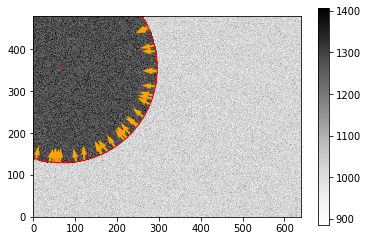

In [64]:
plt.imshow(circles[0], origin='lower', cmap=cm.Greys)
plt.colorbar()
plt.quiver(points[0,:], points[1,:], points[2,:], points[3,:], color='orange', headwidth=3)
circle1 = plt.Circle((mle_params[1], mle_params[2]), mle_params[0], color='r', fill=False)
circle2 = plt.Circle((mle_params[1], mle_params[2]), 2.0, color='r', fill=True)
ax = plt.gca()
ax.add_artist(circle1)
ax.add_artist(circle2)
plt.savefig("sample.pdf")
print(mle_params)